# Spatially-informed Bivariate Metrics

This tutorial provides an overview of the local scores implemented in LIANA+. These scores are used to identify spatially co-expressed ligand-receptor pairs. However, there also applicable to other types of spatially-informed bivariate analyses.

It provides brief explanations of the mathematical formulations of the scores; these include adaptation of bivariate Moran's R, Pearson correlation, Spearman correlation, weighted Jaccard similarity, and cosine similarity. The tutorial also showcases interaction categories (masks) and significance testing. 

## Environement Setup

In [66]:
import scanpy as sc
import plotnine as p9
import decoupler as dc
import liana as li

from mudata import MuData

### Load and Normalize Data

To showcase LIANA's local functions, we will use an ischemic 10X Visium spatial slide from [Kuppe et al., 2022](https://www.nature.com/articles/s41586-022-05060-x). It is a tissue sample obtained from a patient with myocardial infarction, specifically focusing on the ischemic zone of the heart tissue. 

The slide provides spatially-resolved information about the cellular composition and gene expression patterns within the tissue.

In [2]:
adata = sc.read("kuppe_heart19.h5ad", backup_url='https://figshare.com/ndownloader/files/41501073?private_link=4744950f8768d5c8f68c')
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [3]:
adata.obs.head()

in_tissue  array_row  array_col           sample  \
AAACAAGTATCTCCCA-1          1         50        102  Visium_19_CK297   
AAACAATCTACTAGCA-1          1          3         43  Visium_19_CK297   
AAACACCAATAACTGC-1          1         59         19  Visium_19_CK297   
AAACAGAGCGACTCCT-1          1         14         94  Visium_19_CK297   
AAACAGCTTTCAGAAG-1          1         43          9  Visium_19_CK297   

                    n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
AAACAAGTATCTCCCA-1               3125                 8.047510        7194.0   
AAACAATCTACTAGCA-1               3656                 8.204398       10674.0   
AAACACCAATAACTGC-1               3013                 8.011023        7339.0   
AAACAGAGCGACTCCT-1               4774                 8.471149       14235.0   
AAACAGCTTTCAGAAG-1               2734                 7.913887        6920.0   

                    log1p_total_counts  pct_counts_in_top_50_genes  \
AAACAAGTATCTCCCA-1            8.881142                   24.770642   
AAACAATCTACTAGCA-1            9.275660                   35.956530   
AAACACCAATAACTGC-1            8.901094                   33.247036   
AAACAGAGCGACTCCT-1            9.563529                   22.739726   
AAACAGCTTTCAGAAG-1            8.842316                   35.664740   

                    pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
AAACAAGTATCTCCCA-1                    31.387267                    39.797053   
AAACAATCTACTAGCA-1                    42.167885                    49.456624   
AAACACCAATAACTGC-1                    39.910069                    47.227143   
AAACAGAGCGACTCCT-1                    29.884089                    37.850369   
AAACAGCTTTCAGAAG-1                    42.268786                    50.000000   

                    pct_counts_in_top_500_genes   mt_frac celltype_niche  \
AAACAAGTATCTCCCA-1                    54.503753  0.085630      ctniche_1   
AAACAATCTACTAGCA-1                    61.045531  0.033275      ctniche_5   
AAACACCAATAACTGC-1                    59.326884  0.029139      ctniche_5   
AAACAGAGCGACTCCT-1                    51.099403  0.149194      ctniche_7   
AAACAGCTTTCAGAAG-1                    62.384393  0.025601      ctniche_5   

                   molecular_niche  
AAACAAGTATCTCCCA-1      molniche_9  
AAACAATCTACTAGCA-1      molniche_3  
AAACACCAATAACTGC-1      molniche_3  
AAACAGAGCGACTCCT-1      molniche_2  
AAACAGCTTTCAGAAG-1      molniche_3

Spot clusters

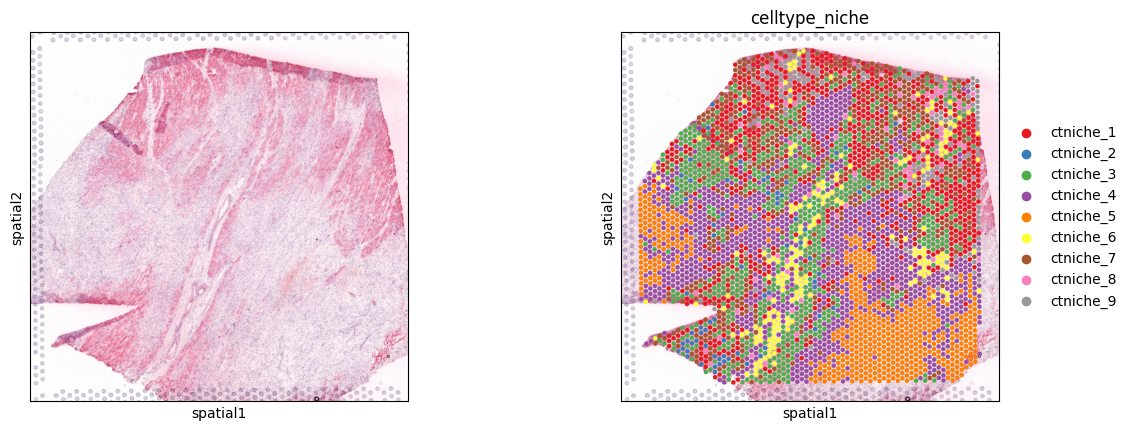

In [4]:
sc.pl.spatial(adata, color=[None, 'celltype_niche'], size=1.3, palette='Set1')

## Background

Here, we will demonstrate how to use the spatially-informed bivariate metrics to assess the spatial relationship between two variables. Specifically, we focus on local bivariate similarity metrics. In contrast to most spatial Methods, including [Misty](https://liana-py.readthedocs.io/en/latest/notebooks/misty.html); focusing on local spatial relationships enables us to pinpoint the exact location of spatial relationships, and to identify spatial relationships that might occur only in a specific sub-region of our samples.

Following the initial concept of LIANA, and inspired by [scHOT](https://www.nature.com/articles/s41592-020-0885-x), we have natively re-implemented **6** local bivariate metrics, including scHOT's (default) masked Spearman & [SpatialDM's](https://www.biorxiv.org/content/10.1101/2022.08.19.504616v1.full) local Moran's R.

As part of the LIANA+ manuscript, we performed two distinct tasks to evaluate the ability of these methods to preserve biological information, and saw that on average when used to identify local ligand-receptor relationships, spatially-weighted Cosine distance did best. Thus, we will focus on it throughout this tutorial. However, we expect that other scoring functions might be better suited for other tasks, e.g. Spatially-weighted Jaccard Similarity should be well suited for categorical data; thus we encourage you to explore them.

### Available Local Functions

In [5]:
li.mt.show_functions()

name                                   metadata  \
0          pearson   weighted Pearson correlation coefficient   
1         spearman  weighted Spearman correlation coefficient   
2           cosine                 weighted cosine similarity   
3          jaccard                weighted Jaccard similarity   
4           morans                                  Moran's R   
5  masked_spearman     masked & weighted Spearman correlation   

                                           reference  
0                                               None  
1                                               None  
2                                               None  
3                                               None  
4  Li, Z., Wang, T., Liu, P. and Huang, Y., 2022....  
5  Ghazanfar, S., Lin, Y., Su, X., Lin, D.M., Pat...

### How do they work?

The local functions work are quite simple, as they are simply weighted versions of well known similarity metrics. For example, the spatially-weighted version of Cosine similarity is defined as:

$$cosw_j(x,y) = \frac{\sum_{i=1}^n w_{ij} x_{i} y_{i}}{\sqrt{\sum_{i=1}^n w_{ij} x_{i}^2} \sqrt{\sum_{i=1}^n w_{ij} y_{i}^2}}$$


where for each spot **c** in position **j**, we perform summation over all spots **n**, where **w**​ represents the spatial connectivity weights from spot **j** to spot **i**;  for variables  **x** and **y**.

### Spatial Connectivity

The way that spatially-informed methods usually work is by making use of weights based on the proximity (or spatial connectivity) between spots/cells.
These spatial connectivities are then used to calculate the metric of interest, e.g. Cosine similarity, in a spatially-informed manner.

The spatial weights in LIANA+ are by default defined as a family of radial kernels that use the inverse Euclidean distance between cells/spots to bind the weights between 0 and 1, with spots that are closest having the highest spatial connectivity to one another (1), while those that are thought to be too far to be in contact are assigned 0.

In [6]:
li.mt.spatial_neighbors(adata, bandwidth=200, cutoff=0.1, kernel='gaussian', set_diag=True)

Key parameters of spatial_neighbors include:
- `bandwidth` controls the radius of the spatial connectivities where higher values will result in a broader area being considered (controls the radius relative to the coordinates stored in `adata.obsm['spatial']`)
- `cutoff` controls the minimum value that will be considered to have a spatial relationship (anything lower than the `cutoff` is set to 0).
- `kernel` controls the distribution of the weights ('gaussian' by default)
- `set_diag` sets the diagonal (i.e. the weight for each spot to itself) to 1 if True. **NOTE**: Here we set it to True as we expect many cells to be neighbors of themselves within a visium spot

Consider changing the parameters to see how they affect the spatial connectivities.

Let's visualize the spatial weights for a single spot to all other spots in the dataset:

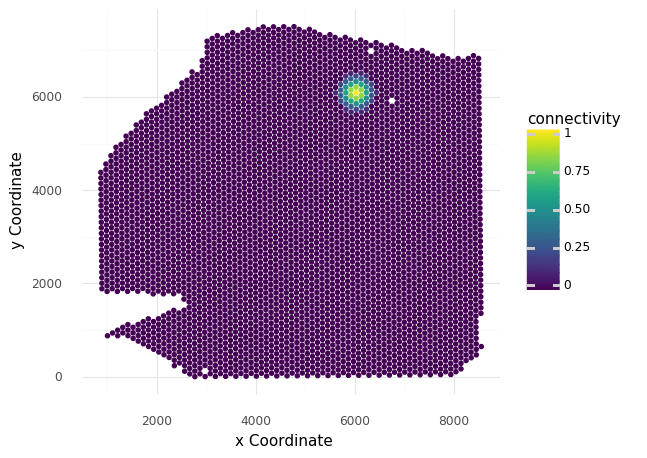

<ggplot: (8783498264303)>

In [7]:
li.pl.connectivity(adata, idx=0, size=1.3)

<div class="alert alert-success">

LIANA's connectivities are flexible and can be defined in any way that fits the user. We have thus aligned LIANA's `spatial_neighbors` function to Squidpy's `spatial_neighbors` function.
A perfectly viable and equally arbitrary solution would be to use Squidpy's nearest neighbors graph, which one can use to easily replace LIANA's radial connecitivies

</div>

### Local Ligand-Receptor Relationships

Now that we have covered the basics, let's see how these scores look for potential ligand-receptor interactions on our 10X Visium Slide.
Note that LIANA+ will take the presence of heteromeric complexes into account at the individual spot-level!

In [8]:
li.mt.lr_bivar(adata, 
               function_name='cosine', # Name of the function
               n_perms=100, # Number of permutations to calculate a p-value
               positive_only=False, # Whether to focus on positive correlations only
               add_categories=True, # Whether to add local categories to the results
               expr_prop=0.2, # Minimum expr. proportion for ligands/receptors and their subunits
               use_raw=False,
               verbose=True
               )

Using `.X`!


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


Now that this is done, we can extract and explore the newly-created AnnData object that counts our local scores

In [9]:
lrdata = adata.obsm['local_scores']

In addition to the local scores, we can also extract the "global" scores for each pair of variables. For most local functions currently in LIANA+, These scores are calculated by averaging the local scores across all spots. We can use the "global" scores to choose the best pairs of variables to visualize:


In [10]:
lrdata.uns['global_res'].sort_values("global_mean", ascending=False).head(3)

ligand receptor  ligand_means  ligand_props  receptor_means  \
2758   TIMP1     CD63      3.048890      0.996839        2.887192   
266   LGALS1    ITGB1      3.534027      0.997326        2.457884   
274      LUM    ITGB1      3.173511      0.996353        2.457884   

      receptor_props   interaction  global_mean  global_sd  
2758        0.994165    TIMP1&CD63     0.981958   0.013757  
266         0.988330  LGALS1&ITGB1     0.978952   0.027114  
274         0.988330     LUM&ITGB1     0.963635   0.026913

In [11]:
lrdata.uns['global_res'].sort_values("global_sd", ascending=False).head(3)

ligand     receptor  ligand_means  ligand_props  receptor_means  \
2881  S100A1         RYR2      0.697087      0.572332        0.430792   
1796     VTN  ITGAV_ITGB5      0.434514      0.395089        1.108789   
713      LPL        VLDLR      0.791770      0.609531        0.612294   

      receptor_props      interaction  global_mean  global_sd  
2881        0.406516      S100A1&RYR2     0.489952   0.259712  
1796        0.814977  VTN&ITGAV_ITGB5     0.545211   0.234249  
713         0.540725        LPL&VLDLR     0.572515   0.231663

Visualize one of the top hits in terms of Global Mean Cosine Distance, and one of the hits with highest variance in terms of Global Mean Cosine Distance:

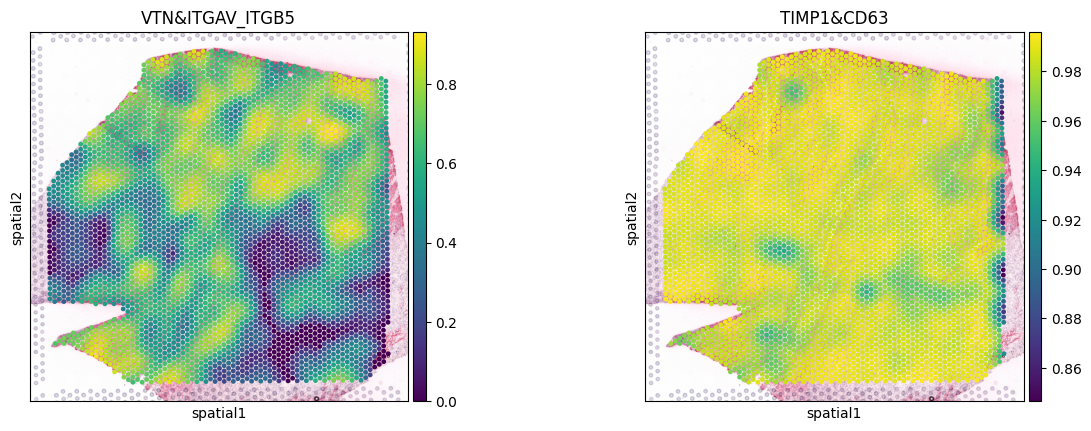

In [12]:
sc.pl.spatial(lrdata, color=['VTN&ITGAV_ITGB5', 'TIMP1&CD63'], size=1.4)

As largely expected, we see that the average Cosine similarity largely represents **coverage**, as *TIMP1 & CD63* are roughly uniformly distributed across the slide. On the other hand, we look among the most variable pairs (e.g. VTN&ITGAV_ITGB5), we see that they are more likely to represent biological relationships, with distinct spatial clustering patterns.

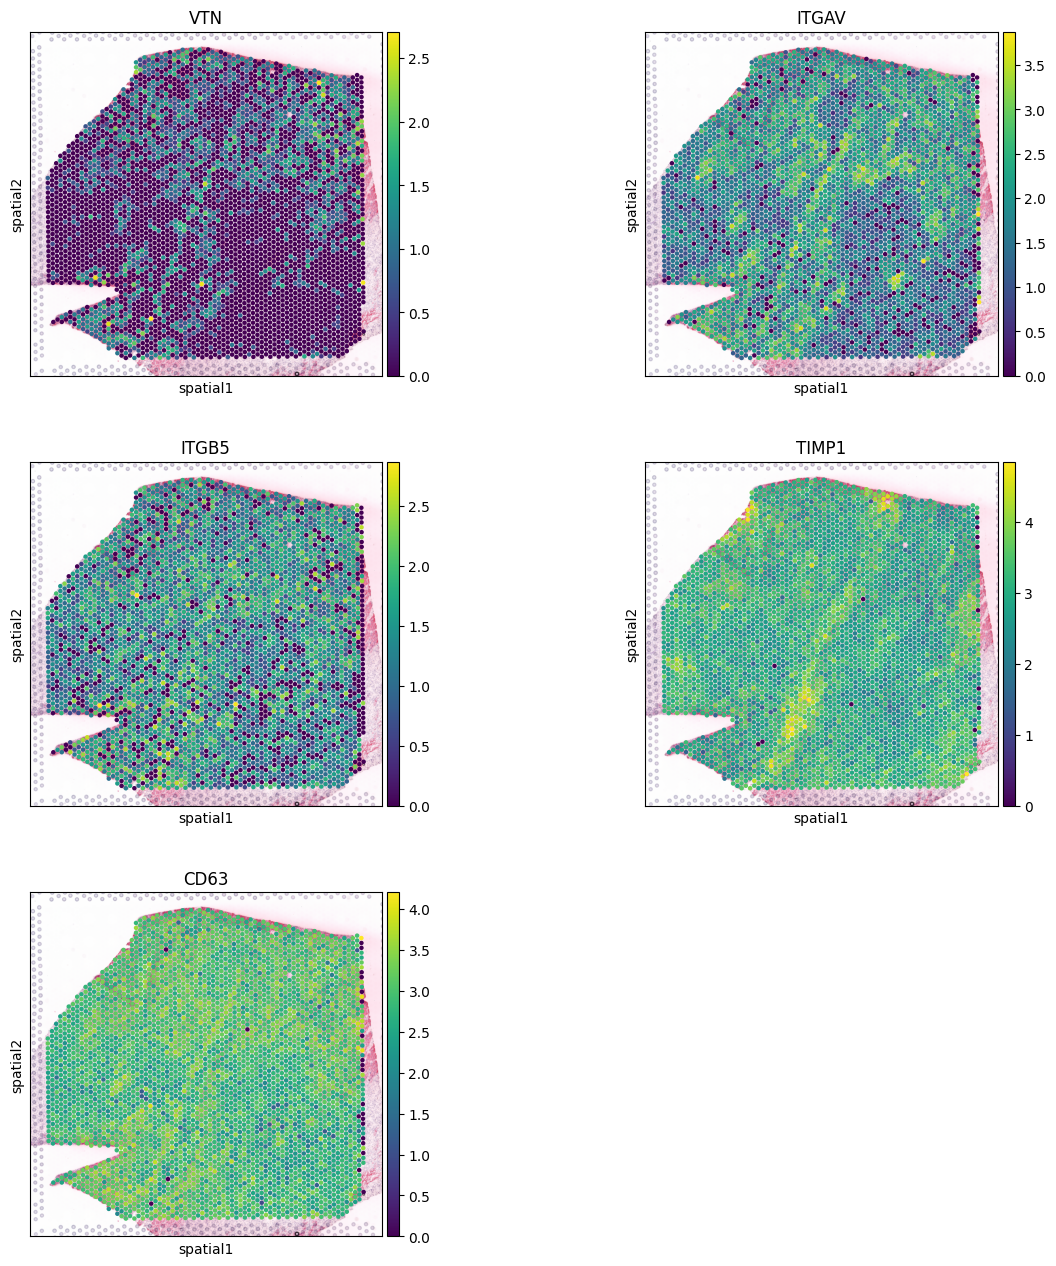

In [13]:
sc.pl.spatial(adata, color=['VTN', 'ITGAV', 'ITGB5', 
                            'TIMP1', 'CD63'],
              size=1.4, ncols=2)

Nevertheless, if we look closely at VTN we can see that it's likely the gene that mostly defines the potential interaction, as the integrin complex (ITGAV, ITGA5) is uniformly expressed.

This also highlight a limitation when using the average or standard deviation of Cosine similarity - i.e. that we don't necessarily focus on interactions between genes that cluster exclusively. To this end, one can use Global bivariate Moran's R - an extension of univariate Moran's I, as proposed by [Anselin 2019](https://onlinelibrary.wiley.com/doi/abs/10.1111/gean.12164?casa_token=Ac3Bb4VIkZUAAAAA:4w9OFifNe33riCnMpNbkghd4ULDokXJ9H9YCqdxebK8yH2ZibqTIAoPRRSzfY9UmCAQBqH6y8FBBsLwgOg); and implemented initially in [SpatialDM](https://github.com/StatBiomed/SpatialDM).

### Global Moran's R

As proposed in SpatialDM, we have re-implemented a bivariate extension of Moran's I = bivariate Moran's R. A nice property of Bivariate Moran's R is that it is bound between -1 (perfect negative spatial correlation) and 1 (perfect positive spatial correlation). Thus, it can be used to identify pairs of variables that are spatially clustered together, or apart.

In [14]:
global_morans, _, _, _ = li.mt.lr_bivar(adata, function_name="morans", inplace=False, use_raw=False)

/home/dbdimitrov/Repos/liana-py/liana/method/sp/_spatial_pipe.py:356: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [15]:
global_morans.sort_values("global_r", ascending=False).head(5)

ligand     receptor  ligand_means  ligand_props  receptor_means  \
70        APOE         LRP1      1.179983      0.752006        1.937682   
2881    S100A1         RYR2      0.697087      0.572332        0.430792   
96    SERPING1         LRP1      1.711175      0.931437        1.937682   
1278       VTN  ITGAV_ITGB1      0.434514      0.395089        1.713479   
75         MDK         LRP1      1.127114      0.789691        1.937682   

      receptor_props      interaction  global_r global_pvals  
70          0.956236        APOE&LRP1  0.284863         None  
2881        0.406516      S100A1&RYR2  0.271809         None  
96          0.956236    SERPING1&LRP1  0.243950         None  
1278        0.929006  VTN&ITGAV_ITGB1  0.235151         None  
75          0.956236         MDK&LRP1  0.227208         None

In this case, we see that the *VTN&ITGAV_ITGB1* is also among one of the interactions whose gene members are among the most spatially-clustered ones, but it also gives us additional information that the clustering between these is not exactly ideal (~0.3); i.e. while there is indeed a positive relationship between the two members of this interaction, their co-expression is not necessarily exclusive. This might be due to the fact that the integrin complex is also expressed in other cell types, or possibly the slightly noisy reads.

<div class="alert alert-info">
  While Moran's R provides a sound summary of spatial clustering, it is limited to two variables at a time and is thus not fit for complex, or non-linear, spatial relationships between variables. Thus, we also encourage the user to explore <a href="https://liana-py.readthedocs.io/en/latest/notebooks/misty.html">LIANA+'s re-implementation of MISTy</a>.
</div>




### Permutation-based p-values
In addition to the local scores, we also calculated permutation-based p-values based on a null distribution generated by shuffling the spot labels. Let's see how these look for the tw interactions from above: 

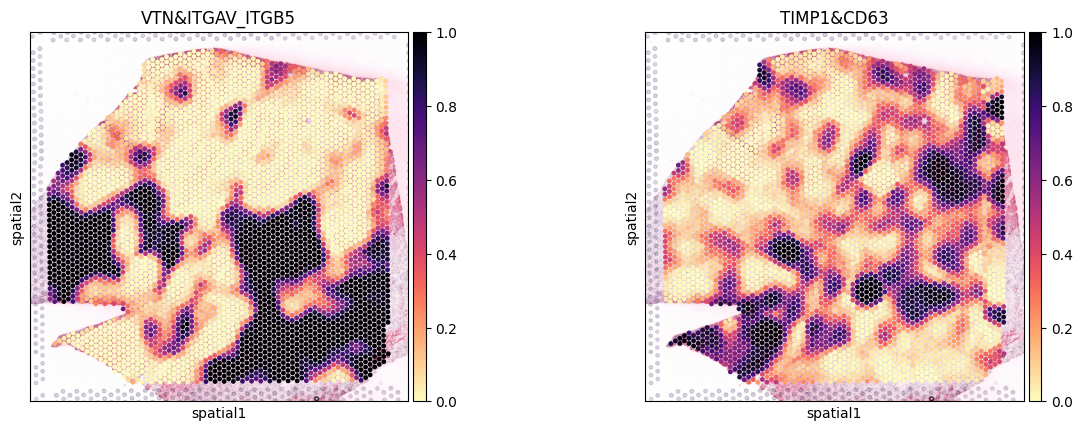

In [16]:
# swap to the p-value layer
dc.swap_layer(lrdata,
              layer_key='pvals', # swap to the p-value layer
              X_layer_key='local', # save the current layer to 'local' 
              inplace=True)
# plot p-values
sc.pl.spatial(lrdata, color=['VTN&ITGAV_ITGB5', 'TIMP1&CD63'], size=1.4, cmap="magma_r")

These largely agree with what we saw above for *VTN&ITGAV_ITGB1* as it more is specific to a certain region. However, the p-values for TIMP1&CD63 are largely driven by 

### Local Categories

Did you notice that we used `positive_only` as a parameter when first estimating the interaction? This essentially means that we can focus only on positive interactions when calculating the p-values, i.e. such which occur at places in which both members of the interaction are highly expressed. The locations at which both members are highly- expressed is defined as follows:

For each interaction, we define the category of both **x** and **y** for each spot as follows:

$$ Category_{j}(x) =
\begin{cases} 
\text{positive}, & \text{if } \sum_{i,j} (x_{i} \cdot w_{ij}) > 0 \\
\text{negative}, & \text{if } \sum_{i,j} (x_{i} \cdot w_{ij}) < 0 \\
\text{neither}, & \text{otherwise} 
\end{cases}

$$

Then we combine the categories of **x** and **y** for each spot, such that high-high are positive (1), high-low (or low-high) are -1; and low-low are 0.
When working with non-negative values (i.e. gene expression); the features will be z-scaled (across observations).

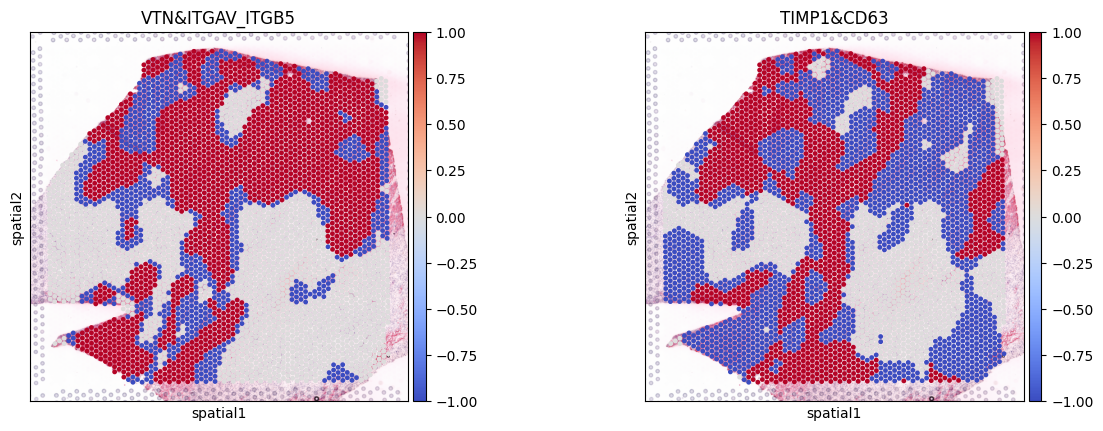

In [17]:
# swap to the categories layer
dc.swap_layer(lrdata, 'cats', inplace=True)
# plot p-values
sc.pl.spatial(lrdata, color=['VTN&ITGAV_ITGB5', 'TIMP1&CD63'], size=1.4, cmap="coolwarm")

Here, we can distinguish areas in which the interaction between interaction members is positive (high-high) in Red (1), while interactions in which one is high the other is low or negative (High-low) are in Blue (-1). We also see that some interactions are neither, these are predominantly interactions in which both members are lowly-expressed (i.e. low-low); we see those in white (0).

When set to `positive_only=False`, we also return interactions that are not necessarily positive ; when set to `positive_only=True`, we only return interactions that are positive (or high-high); for both the p-values and the local scores.

## Identify Cell-cell Communication Niches

Now that we have estimated ligand-receptor scores, we can use non-negative matrix factorization (NMF) to identify coordinated cell-cell communication signatures.
This would ultimately decompose the ligand-receptor scores into a basis matrix (`W`) and a coefficient matrix (`H`). We will use a very simple utility function (around sklearn's NMF implementation) to do so, along with a simple `k` (component number) selection procedure.

* Basis Matrix (`W` - Feature Matrix / Communication signatures):
        Each basis vector represents a characteristic pattern of ligand-receptor expression in the dataset.
        The values in `W` (factor score) indicate the strengths of factor in each spot; high values indicate high influence by the associated communication signature, while low values mean a weak influence.
* Coefficient Matrix (`H` - Coefficient Matrix/ Factor scores):
        Each row of `H` represents the participation of the corresponding sample in the identified factor.
        The elements of each basis vector indicate the contribution of different interactions to the pattern (factor).

![NMF](https://media.geeksforgeeks.org/wp-content/uploads/20210429213042/Intuition1-660x298.png)
### CHANGE THIS TO MY NOTATION, also double check I define it correctly
n=number of interactions; m=number of spots


By decomposing the ligand-receptor interactions into W and H, NMF can potentially identify underlying CCC processes, with additive and non-negative relationships between the features. This property aligns well with the biological intuition that genes work together in a coordinated manner, but assumes linearity and only captures additive effects. Thus, alternative decomposition or clustering approaches (e.g. SpatialDE or MOFA+) can be used to a similar end. 

In this particular scenario, we chose NMF as it is a well-established method for decomposition of non-negative matrices, it is fast, and it is easy to interpret. Also, in our case the ligand-receptor local scores already encode the spatial relationships between the features, so we don't necessarily need to use a spatial-aware decomposition methods (e.g. [SpatialDE](https://www.nature.com/articles/nmeth.4636) or [MEFISTO](https://www.nature.com/articles/s41592-021-01343-9)).

In [153]:
## swap back to local scores layer
dc.swap_layer(lrdata, 'local', inplace=True)

In [154]:
from sklearn.decomposition import NMF
import numpy as np
import pandas as pd

In [155]:
X = lrdata.X

In [156]:
def calculate_reconstruction_error(X, k, **kwargs):
    nmf = NMF(n_components=k, **kwargs)
    W = nmf.fit_transform(X)
    H = nmf.components_
    
    # calculate reconstruction error
    Xhat = np.dot(W, H)
    error = np.mean(np.sqrt((X - Xhat) ** 2))
    
    return error


In [157]:

k_range = range(1, 10)

In [158]:
errors = []
for k in k_range:
    error = calculate_reconstruction_error(X, k, random_state=0, max_iter=200)
    errors.append(error)


/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve con

In [159]:
from kneed import KneeLocator

In [160]:
kneedle = KneeLocator(x=list(k_range), y=errors, direction='decreasing', curve='convex', interp_method='interp1d')

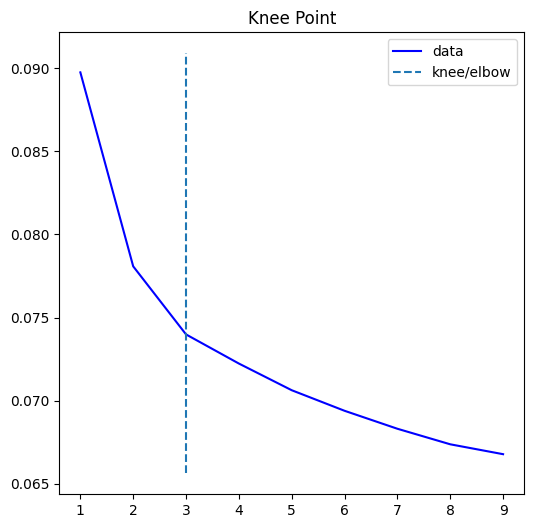

In [161]:
kneedle.plot_knee()

In [162]:
# to df
errors_df = pd.DataFrame(errors, index=list(k_range), columns=['reconstruction_error']).reset_index().rename(columns={'index': 'k'})

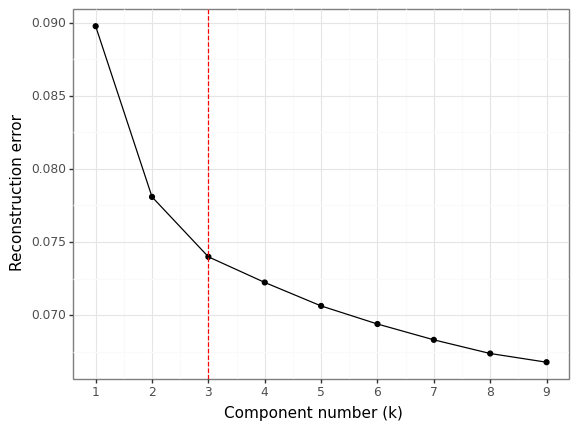

<ggplot: (8783492305788)>

In [163]:
# line plot
(
    p9.ggplot(errors_df, p9.aes(x='k', y='reconstruction_error')) +
    p9.geom_line() +
    p9.geom_point() +
    p9.theme_bw() +
    p9.scale_x_continuous(breaks=errors_df['k'].values) +
    p9.labs(x='Component number (k)', y='Reconstruction error') +
    # vertical line
    p9.geom_vline(xintercept=kneedle.knee, linetype='dashed', color='red')
)

In [164]:
# Create an instance of the NMF class
model = NMF(n_components=kneedle.knee, init='random', random_state=0)

In [165]:
# Fit the model to the data and obtain the factorized matrices
W = model.fit_transform(lrdata.X)
H = model.components_

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.


TODO: CHECK MY NAMING CONVENTION, am I using W and H correctly?

In [166]:
W.shape

(4113, 3)

In [167]:
H.shape

(3, 642)

In [168]:
 ## NOTE take index from adata.obs.index, not from the obsm matrix
columns = [f"Factor{i+1}" for i in range(W.shape[1])]

In [169]:
lrdata.obsm['NMF_W'] = pd.DataFrame(W, index=lrdata.obs.index, columns=columns)
lrdata.varm['NMF_H'] = H.T 

In [171]:
nmf = li.fun.obsm_to_adata(lrdata, 'NMF_W')

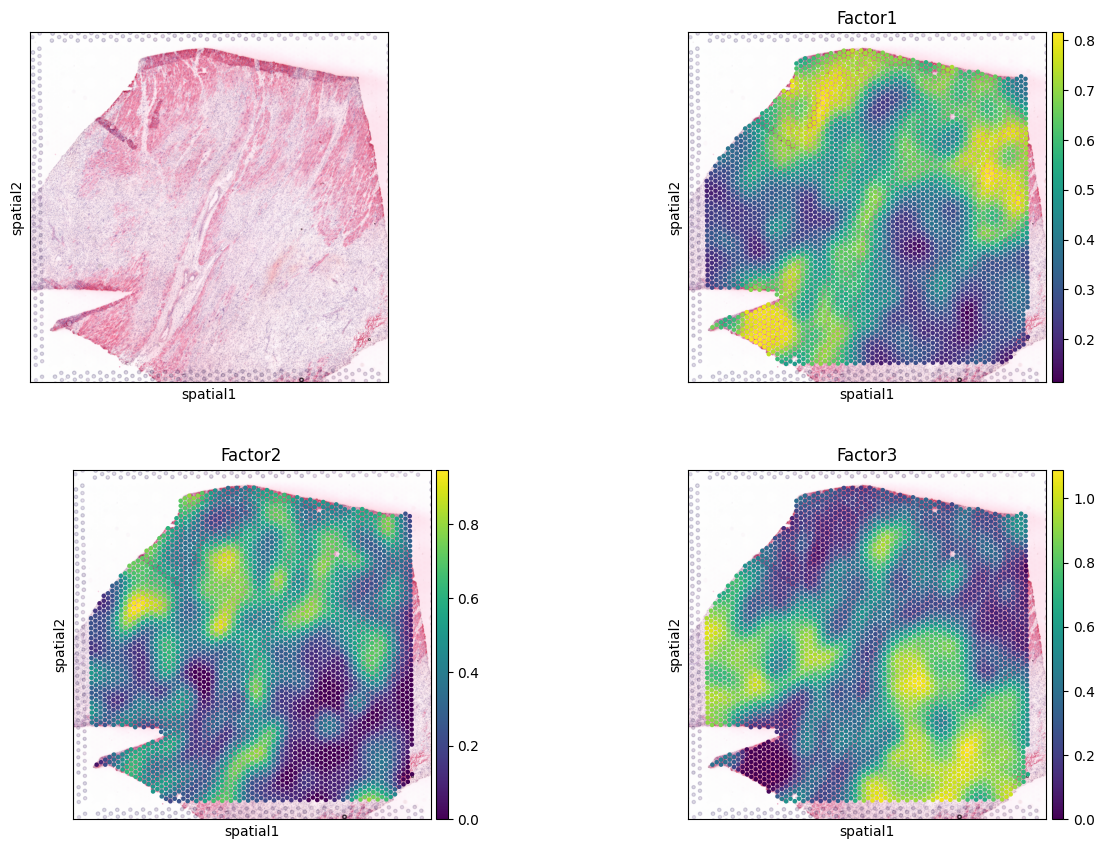

In [179]:
sc.pl.spatial(nmf, color=[None, 'Factor1', 'Factor2', 'Factor3'], size=1.4, ncols=2)

Wee see that Factor 3 is largely covering the ischemic areas of the side

In [193]:
# let's check the most contributing interactions
# TODO: change this to whatever I use in MOFA
h = pd.DataFrame(lrdata.varm['NMF_H'], 
                 columns=[f"Factor{i+1}" for i in range(lrdata.varm['NMF_H'].shape[1])],
                 index=lrdata.var.index)

In [196]:
h.sort_values("Factor3", ascending=False).head(10)

Factor1   Factor2   Factor3
interaction                                
APOE&LRP1      0.516924  0.265399  0.856647
MDK&LRP1       0.579612  0.317812  0.809670
C3&LRP1        0.343614  0.111263  0.802490
SERPING1&LRP1  0.816046  0.245096  0.792860
C3&CD81        0.415282  0.001531  0.778614
VCAN&ITGB1     0.951949  0.163888  0.778134
C1QB&LRP1      0.823263  0.228288  0.777770
PSAP&LRP1      0.981446  0.175201  0.772625
S100A9&CD68    0.578864  0.250973  0.767542
FBN1&ITGB1     1.012879  0.130765  0.766658

In [ ]:
## Do we do some pathway stuff?

## Beyond Ligand-Receptors

While protein-mediated ligand-receptor interactions are interesting, cell-cell communication is not limited to those alone. Rather it is a complex process that involves a variety of different mechanisms such as signalling pathways, metabolite-mediated signalling, and distinct cell types.

So, if such diverse mechanisms are involved in cell-cell communication, why should we limit ourselves to ligand-receptor interactions?
Let's see how we can use LIANA+ to explore other types of cell-cell communication.

One simple approach would be to check relationships e.g. between transcription factors and cell type proportions.

#### Extract Cell type Composition
This slide comes with estimated cell type proportions using cell2location; See [Kuppe et al., 2022](https://www.nature.com/articles/s41586-022-05060-x). Let's extract from .obsm them to an independent AnnData object.

In [ ]:
# let's extract those
comps = li.fun.obsm_to_adata(adata, 'compositions')
# check key cell types
sc.pl.spatial(comps, color=['vSMCs','CM', 'Endo', 'Fib'], size=1.3, ncols=2)

#### Estimate Transcription Factor Activity

While multi-omics datasets might be even more of an interest, for the sake of simplicity (and because the general lack of spatial mutli-omics data at current times), let's instead use enrichment analysis to estimate the activity of transcription factors in each spot. We will use one of [decoupler-py's](https://decoupler-py.readthedocs.io/en/latest/index.html) enrichment methods with [CollectTRI](https://www.biorxiv.org/content/10.1101/2023.03.30.534849v1.abstract) to do so. Refer to this [tutorial](https://decoupler-py.readthedocs.io/en/latest/notebooks/dorothea.html) for more info.

In [ ]:
# Get transcription factor resource
net = dc.get_collectri()

# run enrichment
dc.run_ulm(adata, net=net, use_raw=False, verbose=True)

##### Extract highly-variable TF activities
To reduce the number of TFs for the sake of computational speed, we will only focus on the top 50 most variable TFs.

Note we will use the simple coefficient of variation to identify the most variable TFs, but one can also use more sophisticated or spatially-informed methods to extract those (light-weight suggestions are welcome).


In [ ]:
est = li.fun.obsm_to_adata(adata, 'ulm_estimate')
est.var['cv'] =  est.X.std(axis=0) / est.X.mean(axis=0)
top_tfs = est.var.sort_values('cv', ascending=False, key=abs).head(50).index


To make the distributions comparable, we will simply z-scale the TF activities and cell type proportions.

In [ ]:
# TODO: ADD A NOTE ON SCALING + also point to minmax scaling

In [ ]:
sc.pp.scale(comps)
sc.pp.scale(est)

Create MuData object with TF activities and cell type proportions, and transfer spatial connectivities and other information from the original AnnData object.

In [ ]:
mdata = MuData({"tf":est, "comps":comps})
mdata.obsp = adata.obsp
mdata.uns = adata.uns
mdata.obsm = adata.obsm

Define Interactions of interest:

In [ ]:
from itertools import product

In [ ]:
interactions = list(product(comps.var.index, top_tfs))

#### Estimate Cosine Similarity

In [ ]:
li.mt.bivar(mdata,
            x_mod="comps", y_mod="tf", 
            function_name="cosine", 
            interactions=interactions,
            positive_only=False, 
            add_categories=True
            )

In [ ]:
mdata.mod['local_scores'].uns["global_res"].sort_values("global_mean", ascending=False).head(5)

#### Let's plot the results

In [ ]:
sc.pl.spatial(mdata.mod['local_scores'], color=['Myeloid^SNAI2', 'CM^HAND1'], size=1.4, cmap="coolwarm")

In [ ]:
dc.swap_layer(mdata.mod['local_scores'], 'cats', inplace=True)

In [ ]:
sc.pl.spatial(mdata.mod['local_scores'], color=['Myeloid^SNAI2', 'CM^HAND1'], cmap='coolwarm')

In [ ]:
sc.pl.spatial(mdata.mod['tf'], color=['SNAI2', 'HAND1'], cmap='coolwarm', size=1.4, vcenter=0)

In [ ]:
sc.pl.spatial(mdata.mod['comps'], color=['Myeloid', 'CM'], cmap='coolwarm', size=1.4, vcenter=0)

In the case of *HAND1 & CM*, we can clearly see regions (bottom right) in which the local scores are positive, but the values of the two variables are clearly lowly abundant (i.e. low-low or negative-negative). Thus, one could consider masking the local scores or p-values using the local categories, if they wish to focus on interactions in which both members are highly-abundant.